<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/GD/%5BGD_8%5Dseq2seq_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#plt 한글 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/content/drive/MyDrive/Aiffel/data/GD_8/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/content/drive/MyDrive/Aiffel/data/GD_8/NanumBarunGothic.ttf'

In [ ]:
%%capture
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
from tqdm import tqdm    # tqdm
import random

from konlpy.tag import Mecab

print(tf.__version__)

2.8.2


In [ ]:
path = '/content/drive/MyDrive/Aiffel/data/GD_8'
en_path = path + '/korean-english-park.train.en'
ko_path = path + '/korean-english-park.train.ko'
with open(en_path, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [ ]:
with open(ko_path, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


### 데이터 전처리

In [ ]:
cleaned_corpus = set(zip(raw_ko,raw_en))

In [ ]:
def preprocess_sentence(sentence, k_token = False, e_token = False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    if k_token:
        mecab = Mecab()
        sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
        sentence = mecab.morphs(sentence)

    if e_token:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        sentence = '<start> ' + sentence
        sentence += ' <end>'
        sentence = sentence.split()

    return sentence

In [ ]:
eng_corpus = []
kor_corpus = []


for pair in cleaned_corpus:
    pre_kor = preprocess_sentence(pair[0], k_token = True)
    pre_eng = preprocess_sentence(pair[1], e_token = True)
    
    if (len(pre_kor) <= 40) & (len(pre_eng) <= 40): # 길이 40 이하의 토큰만 corpus에 추가 
        eng_corpus.append(pre_eng)
        kor_corpus.append(pre_kor)

In [ ]:
print("English:", eng_corpus[30])  
print("Korean:", kor_corpus[30]) 

English: ['<start>', 'The', 'dead', 'included', 'four', 'men', ',', 'two', 'women', ',', 'a', 'child', 'and', 'another', 'person', ',', 'Sao', 'Paulo', 's', 'state', 'security', 'department', 'said', 'in', 'a', 'statement', '.', '<end>']
Korean: ['상', '파울로', '안', '보부', '는', '성명', '을', '통해', '이번', '사고', '로', '남성', '명', ',', '여성', '명', ',', '어린이', '명', '등', '여러', '명', '이', '사망', '했', '다고', '밝혔', '다', '.']


In [ ]:
print(len(kor_corpus), len(eng_corpus))

63139 63139


In [ ]:
def tokenize(corpus, num_words = 15000):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, filters='')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
eng_tensor, eng_tokenizer = tokenize(eng_corpus)
kor_tensor, kor_tokenizer = tokenize(kor_corpus)

In [ ]:
del eng_corpus
del kor_corpus
del cleaned_corpus

In [ ]:
print("English Vocab Size:", len(eng_tokenizer.index_word))
print("Korean Vocab Size:", len(kor_tokenizer.index_word))


English Vocab Size: 38540
Korean Vocab Size: 37076


### 모델 구현

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 512)
Decoder Output: (64, 38541)
Decoder Hidden State: (64, 512)
Attention: (64, 40, 1)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


### 학습 진행

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    

Epoch 10: 100%|██████████| 987/987 [04:48<00:00,  3.42it/s, Loss 2.0069]


In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence, k_token= True)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  
    fig = plt.figure(figsize=(10,30))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90,fontproperties=font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

### 번역문 생성

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the first time . <end> 


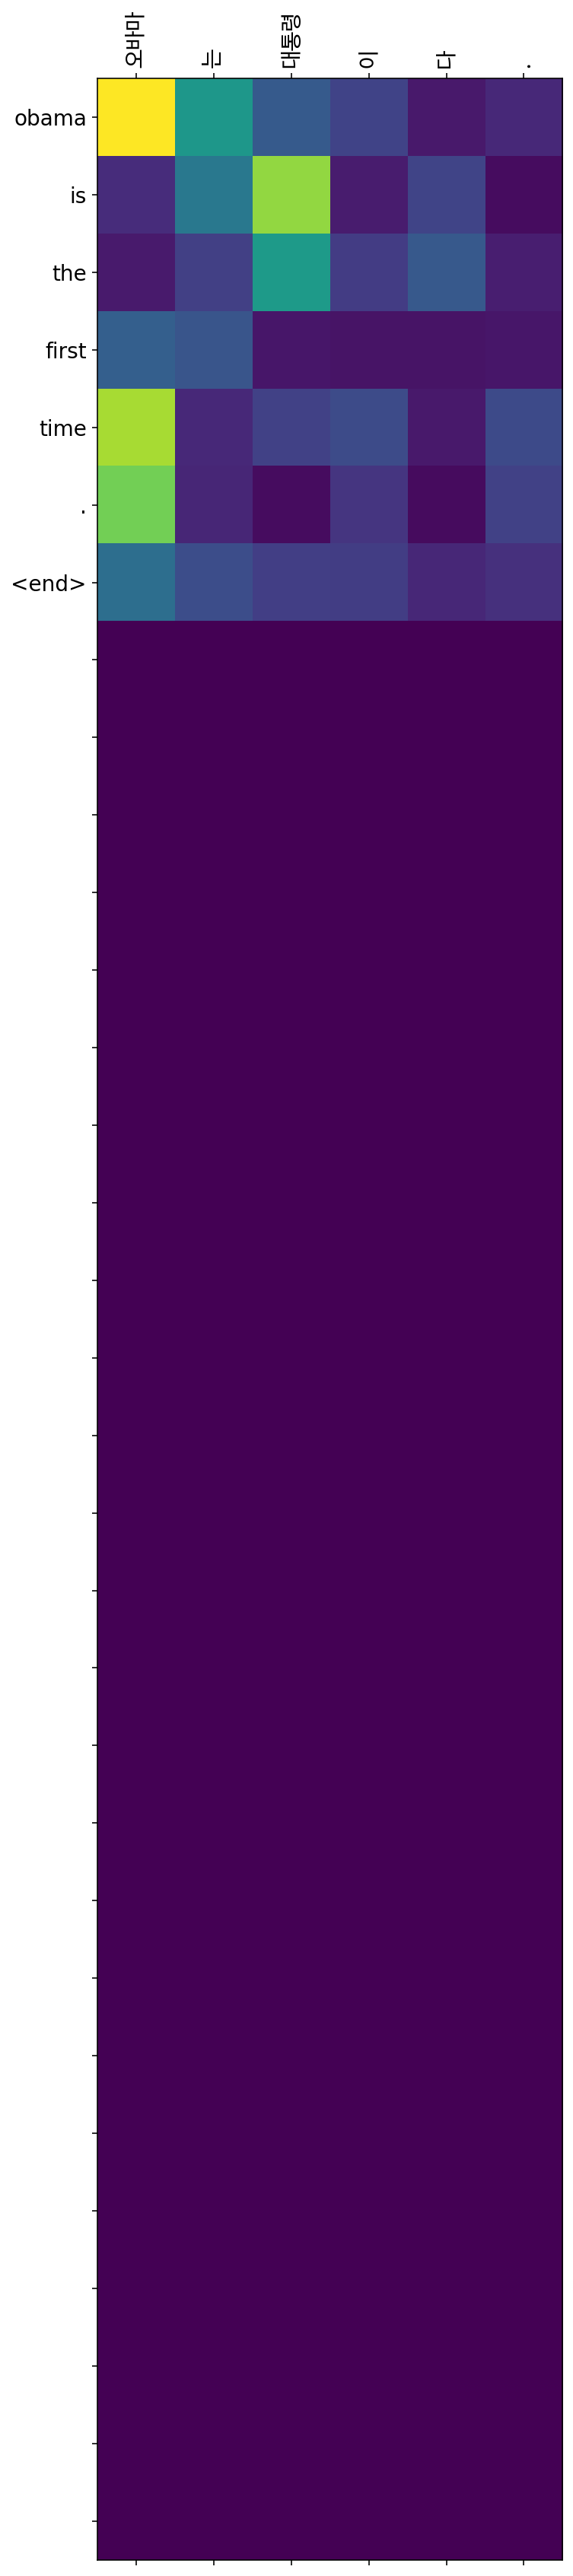

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they were in the day . <end> 


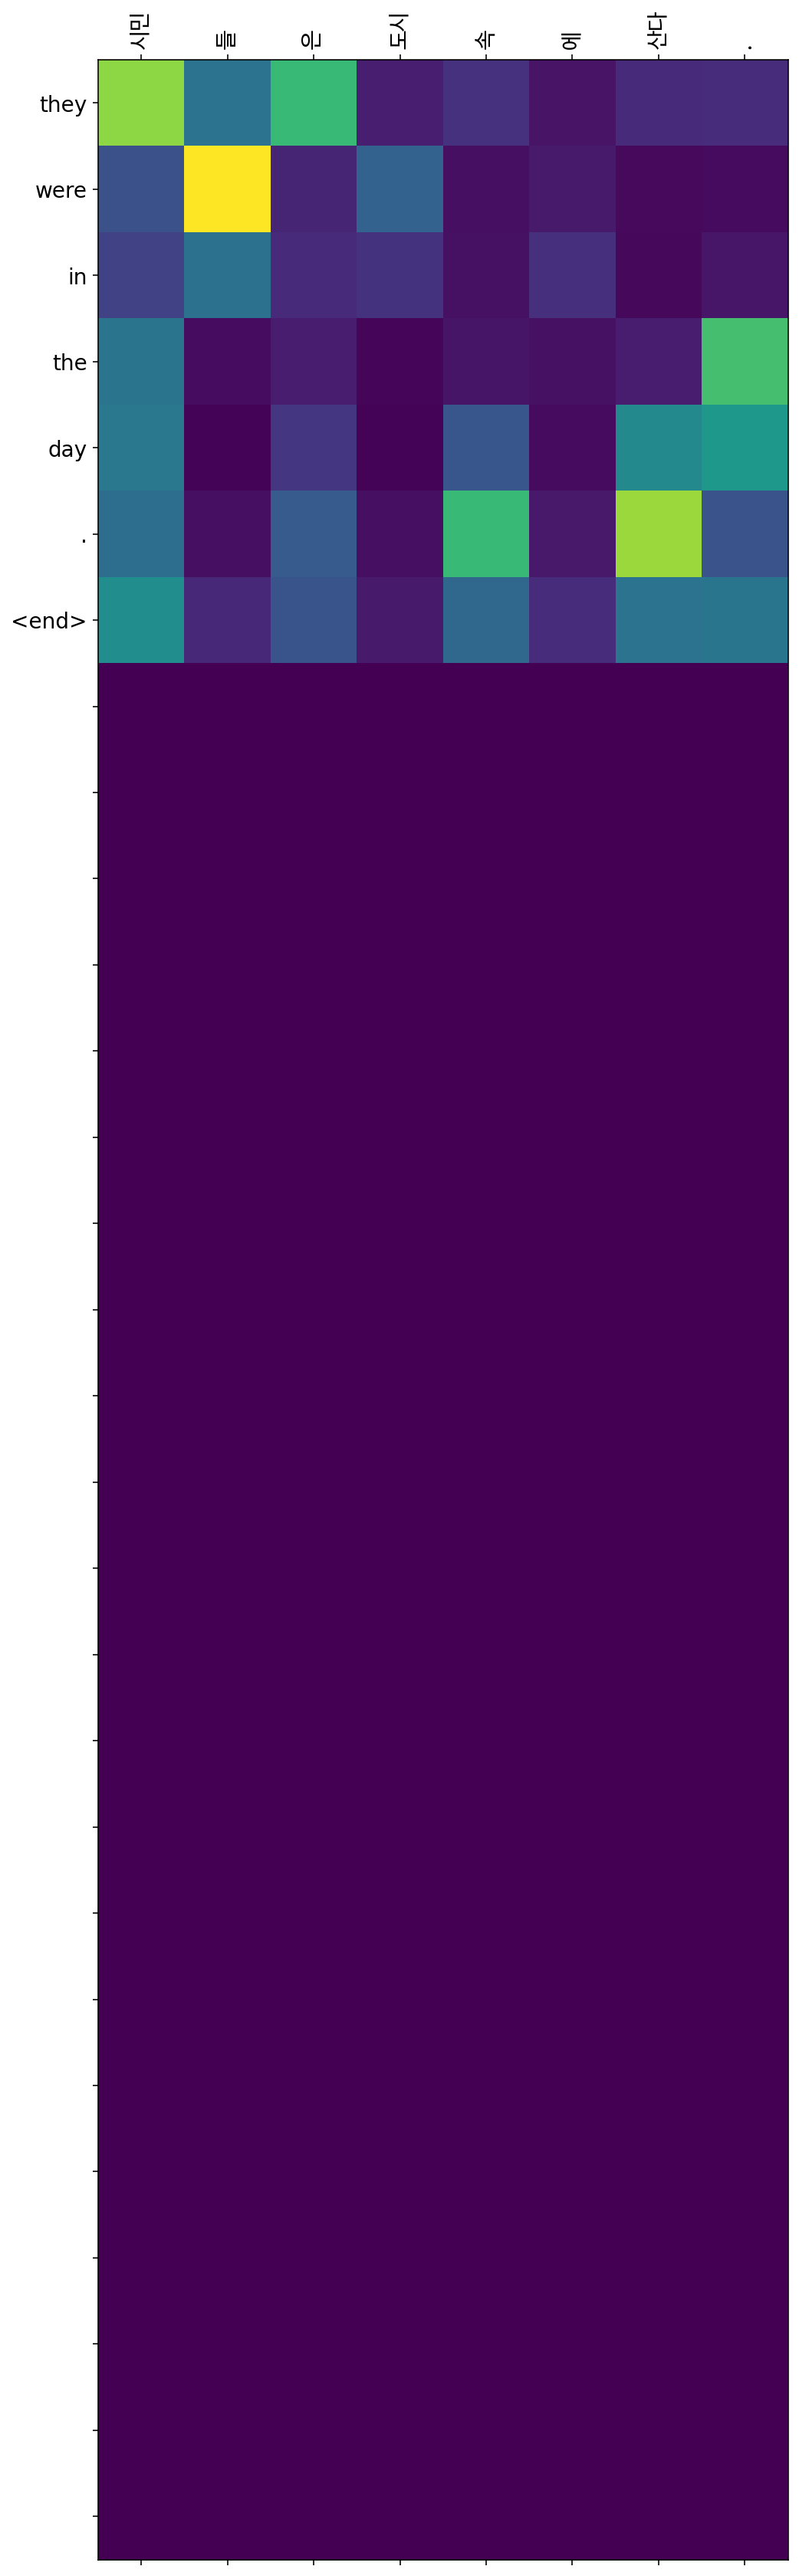

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the device can be . <end> 


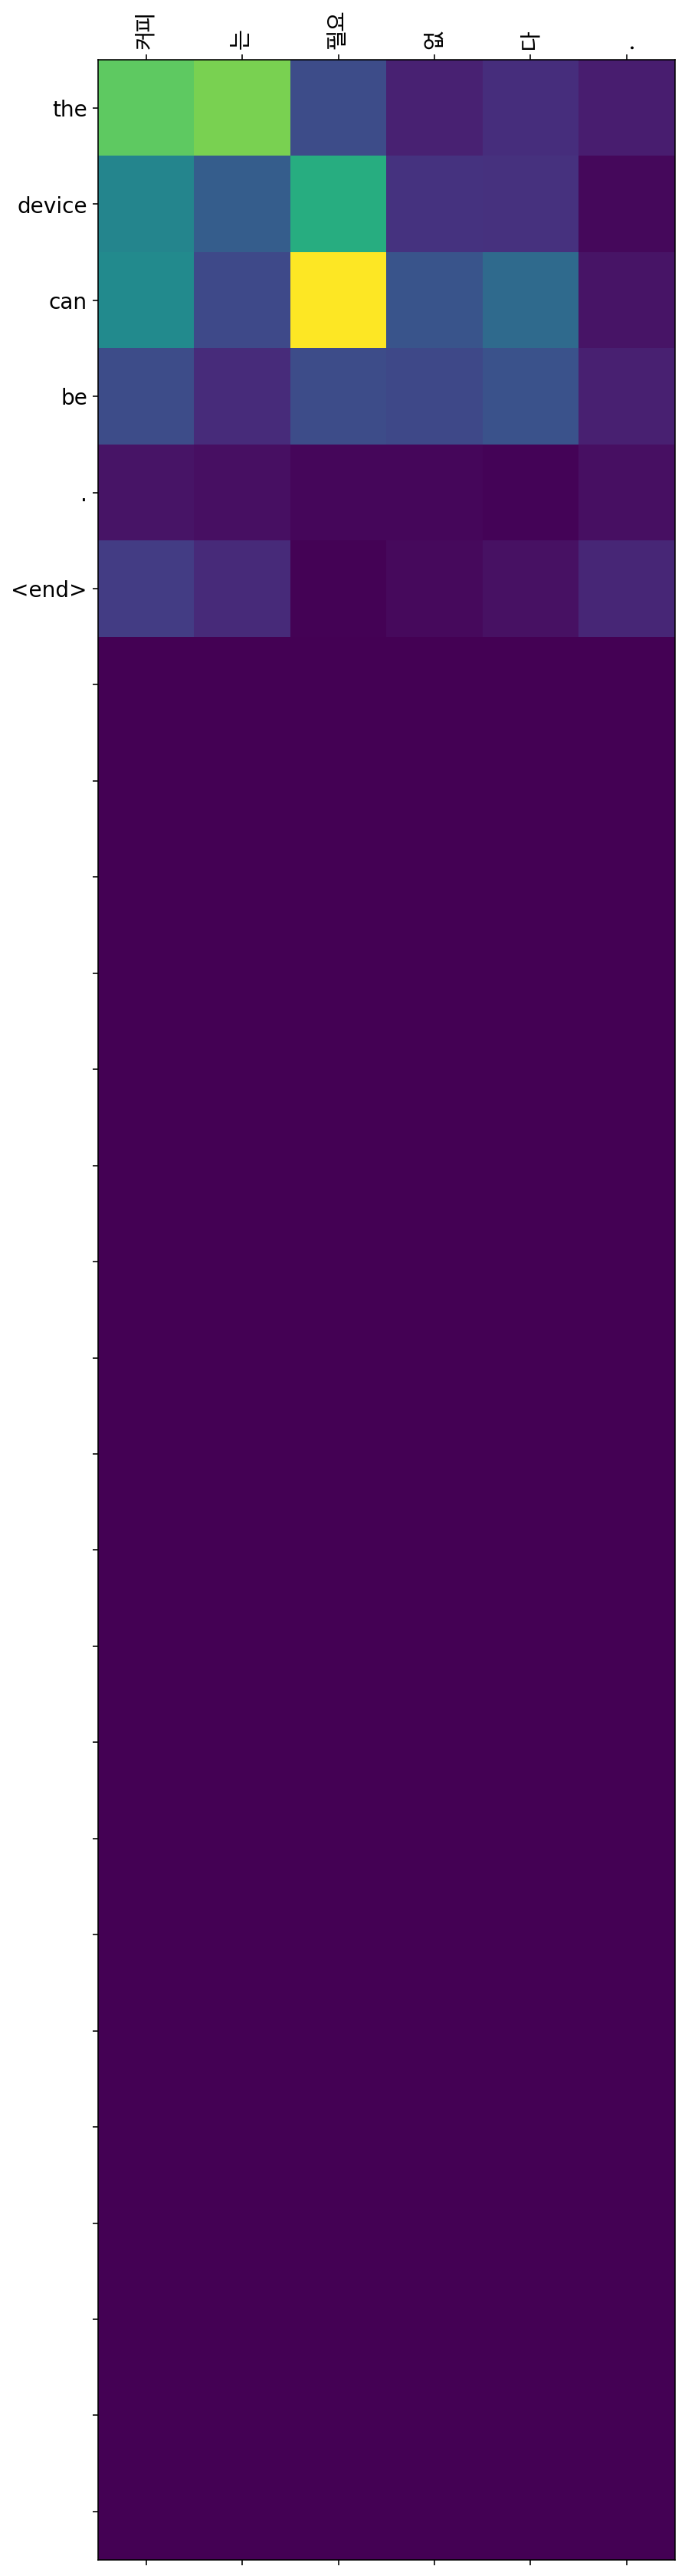

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the two men were killed in the last two days . <end> 


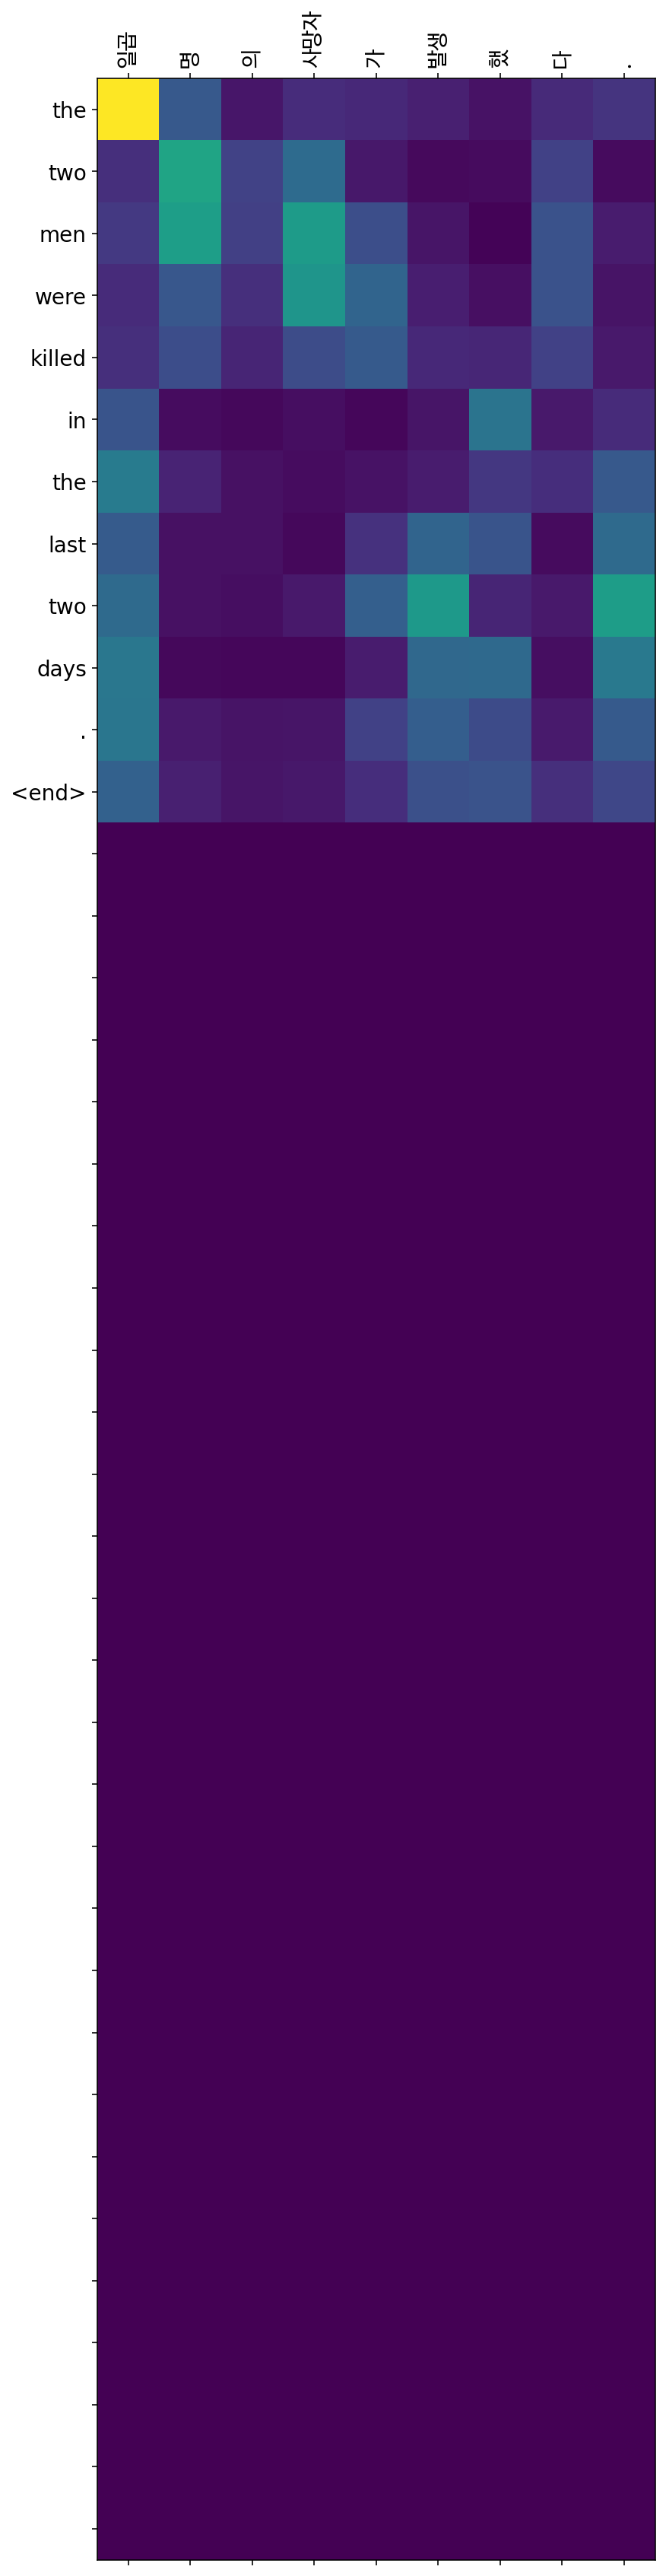

''

In [ ]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)
""

### 회고록
한국어의 vocab size가 어떤 이유에서인지 모르겠지만, 새로 돌릴때 마다 37075,37076의 수치를 기록하였는데 37075일때는 학습진행과정에서 Loss 감소가 매끄럽지 못했다. 37076에는 충분히 잘 내려갔지만 실제로 번역된 결과를 볼때 잘 되었는지는 조금 의문이든다. 
GRU에 dropout,recurrent_dropout = 0.3 추가해서 훈련을 시도하였지만, 번역과정에서 the만 무한 출력하는 현상이 있었다.
(참고 github : https://github.com/hayaseleu/SSAC_classifications/blob/master/Going_deeper(NLP)/Going%20Deeper(NLP)_SSAC%208.%20Seq2seq%EC%9C%BC%EB%A1%9C%20%EB%B2%88%EC%97%AD%EA%B8%B0%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb)